# Earth Observation - Land Classification on EuroSAT dataset

* EuroSAT is a large-scale land use and land cover classification dataset derived from multispectral Sentinel-2 satellite imagery covering European continent. 

* EuroSAT is composed of 27,000 georeferenced image patches (64 x 64 pixels) - each patch comprises 13 spectral bands (optical through to shortwave infrared ) resampled to 10m spatila resolution and labelled with one of 10 distinct land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake. 

* Full details including links to journal papers and download instructions may be found here: https://github.com/phelber/eurosat.

![alt text](https://github.com/phelber/EuroSAT/blob/master/eurosat_overview_small.jpg?raw=true)

##  1. Setup Notebook Environment

### 1.1 Import all required packages.

In [1]:
import ssl
import torch
import random
import numpy as np
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import EuroSAT
from torch.utils.tensorboard.writer import SummaryWriter
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingWarmRestarts

### 1.2 Configure settings for the corresponding optimizers and schedulers.

In [2]:
use_AdamW = True # Flag utilized for switching between AdamW and SGD optimizer.

if use_AdamW:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':20,
            
            # Settings for the optimizer AdamW
            'lr':1e-3, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }
else:
  config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'epochs':100,

            # Settings for the optimizer SGD
            'lr':1e-4, # learning rate
            'weight_decay':5e-4,  
            'momentum':0.9,

            # Settings for the lr_scheduler MultiStepLR
            'milestones':[50,75,90], # List of epoch indices.
            'gamma':0.2, # Multiplicative factor of learning rate decay.
          }

### 1.3 Define a function to set a random seed for reproducibility assurance:
* Manage sources of randomness that may lead to varying behaviors in multiple executions of your application.

In [3]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

### 1.4 Tracks the active GPU and allocates all new CUDA tensors on that device by default.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Data Preparation:

### 2.1 Preparing the dataset:

In [5]:
# Transform pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Dataset download
ssl._create_default_https_context = ssl._create_unverified_context # Turn off the ssl verification.
path = ""
dataset = EuroSAT(root=path, transform=transform, download=True)

# Train/Test split
n = int(len(dataset) * (1 - config['train_test_split']))
eurosat_train, eurosat_test = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

100.0%


Extracting eurosat/EuroSAT.zip to eurosat


### 2.2 Visualize Training Data

Image 20952 's label : 6 PermanentCrop


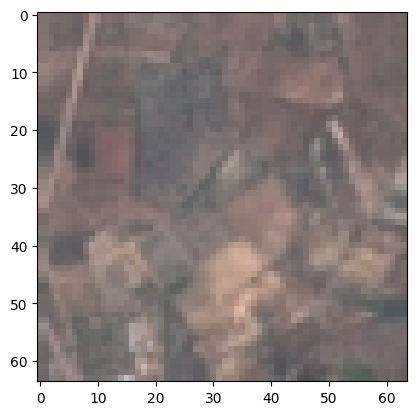

In [9]:
# Randomly select an image from the Training Data for visualization and print its corresponding label.
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(eurosat_train)) # random select an index
random_image = eurosat_train[random_index][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", eurosat_train[random_index][1], classes[eurosat_train[random_index][1]])
plt.imshow(random_image)

### 2.3 Instantiate PyTorch data loader that feeds the image tensors to our neural network

In [10]:
# Tr/Val split
n = int(len(eurosat_train) * config['tr_val_split'])
eurosat_tr, eurosat_val = torch.utils.data.random_split(eurosat_train, [n, len(eurosat_train) - n])

# instantiate data loaders
train_dataloader = torch.utils.data.DataLoader(eurosat_tr, batch_size=config['mini_batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(eurosat_val, batch_size=config['mini_batch_size'], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(eurosat_test, batch_size=config['mini_batch_size'], shuffle=True)

## 3. Model Training

### 3.1 Create a ResNet-50 model using torchvision

ResNet-50 from  Deep Residual Learning for Image Recognition(https://arxiv.org/abs/1512.03385) 
ResNet paper: https://arxiv.org/pdf/1512.03385.pdf

EfficientNet paper: https://arxiv.org/pdf/1905.11946.pdf
EfficientNet2 paper: https://arxiv.org/pdf/2104.00298.pdf

Distillation paper: https://arxiv.org/pdf/2006.05525.pdf

Multimodal paper: https://arxiv.org/pdf/2301.04856.pdf

In [ ]:
num_classes = 10
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3.2 Define criterion, optimizer, and scheduler

In [12]:
criterion = nn.CrossEntropyLoss()

# Experiment with various optimizers and schedulers.
if use_AdamW: 
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config['t_0'], eta_min=config['eta_min'])
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
    scheduler = MultiStepLR(optimizer, milestones=config['milestones'], gamma=config['gamma'])

### 3.3 Define the Training Loop
Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:

* Gets a batch of training data from the DataLoader

* Zeros the optimizer’s gradients

* Performs an inference - that is, gets predictions from the model for an input batch

* Calculates the loss for that set of predictions vs. the labels on the dataset

* Calculates the backward gradients over the learning weights

* Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

* Finally, it reports the averaged epoch loss for comparison with a validation run

In [13]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    train_loss = 0.
    train_acc = 0.
    num_correct = 0
    num_samples = 0

    # Here, we use enumerate(train_dataloader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for _, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.to(device))

        # Compute the loss and its gradients
        loss = criterion(outputs, labels.to(device))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        _, predictions = outputs.max(dim=-1)
        num_correct += (predictions == labels.to(device)).sum()
        num_samples += predictions.size(0)
        
    train_loss = running_loss/len(train_dataloader)
    train_acc = float(num_correct)/float(num_samples)

    return train_loss, train_acc

#### 3.4 Evaluate the Trained Model on Validation Data
* Perform validation by examining the relative loss on a dataset that was not utilized for training.

* Save a copy of the model

* Utilize TensorBoard for reporting. (This necessitates launching TensorBoard from the command line and accessing it in a separate browser tab.)

In [15]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('{}/eurosat_trainer_{}'.format(path, timestamp))
epoch_number = 0
tr_acc = 0.0
best_vloss = 1_000_000.

for epoch in range(config['epochs']):
    print('============= EPOCH {} ============='.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, tr_acc = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    val_acc = 0.0
    num_vcorrect = 0
    num_vsamples = 0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs.to(device))
            vloss = criterion(voutputs, vlabels.to(device))
            running_vloss += vloss
            _, vpredictions = voutputs.max(dim=-1)
            num_vcorrect += (vpredictions == vlabels.to(device)).sum()
            num_vsamples += vpredictions.size(0)

    avg_vloss = running_vloss / len(val_dataloader)
    val_acc = float(num_vcorrect)/float(num_vsamples)
    print('LOSS : train {} | valid {}'.format(round(avg_loss, 4), round(avg_vloss.item(), 4)))
    print('ACC  : train {}% | valid {}%'.format(round(tr_acc*100, 2), round(val_acc*100),2))

    # Log the running loss averaged per epoch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : tr_acc, 'Validation' : val_acc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '{}/model_{}_{}'.format(path, timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

============= EPOCH 1 =============


LOSS : train 2.2237 | valid 2.2239
ACC  : train 15.27% | valid 15%
============= EPOCH 2 =============
LOSS : train 2.0988 | valid 2.1382
ACC  : train 22.49% | valid 20%
============= EPOCH 3 =============
LOSS : train 2.0717 | valid 2.0829
ACC  : train 22.49% | valid 24%
============= EPOCH 4 =============
LOSS : train 2.0433 | valid 2.0974
ACC  : train 25.51% | valid 22%
============= EPOCH 5 =============
LOSS : train 2.0462 | valid 2.1199
ACC  : train 25.0% | valid 21%
============= EPOCH 6 =============
LOSS : train 2.0286 | valid 2.1047
ACC  : train 25.95% | valid 22%
============= EPOCH 7 =============
LOSS : train 2.0115 | valid 2.0422
ACC  : train 26.6% | valid 26%
============= EPOCH 8 =============
LOSS : train 1.9798 | valid 1.9889
ACC  : train 29.49% | valid 29%
============= EPOCH 9 =============
LOSS : train 1.9463 | valid 2.0567
ACC  : train 31.48% | valid 25%
============= EPOCH 10 =============
LOSS : train 1.9608 | valid 2.0527
ACC  : train 29.22% | valid 25%
=======

## 4. Model evaluation on Test Data

### 4.1 Load the model with the lowest validation loss.

In [1]:
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

NameError: name 'models' is not defined

### 4.2 Evaluate the top-performing model on the Test Data.

In [2]:
running_tloss = 0.
test_acc = 0.
num_tcorrect = 0
num_tsamples = 0
with torch.no_grad():
    for _, tdata in enumerate(test_dataloader):
        tinputs, tlabels = tdata
        toutputs = model(tinputs.to(device))
        tloss = criterion(toutputs, tlabels.to(device))
        running_tloss += tloss
        _, tpredictions = toutputs.max(dim=-1)
        num_tcorrect += (tpredictions == tlabels.to(device)).sum()
        num_tsamples += tpredictions.size(0)

avg_tloss = running_tloss/len(test_dataloader)
test_acc = float(num_tcorrect)/float(num_tsamples)
print('LOSS : train {} | valid {} | test {}'.format(round(avg_tloss.item(), 4), round(avg_vloss.item(), 4), round(avg_tloss.item(), 4)))
print('ACC  : train {}% | valid {}%  | test {}%'.format(round(tr_acc*100, 2), round(val_acc*100),2), round(test_acc*100,2))

NameError: name 'torch' is not defined

### 4.3 Predict the label of an image from the Test Data and visualize the image.

Image 0 's label : 2 HerbaceousVegetation | Predicted label : 7 Residential


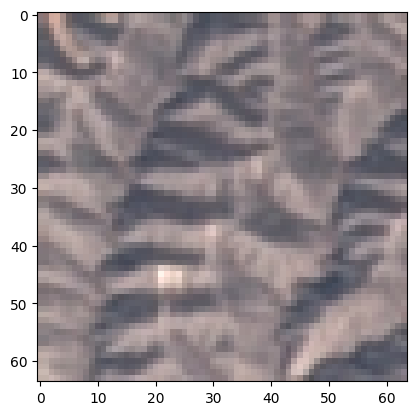

In [21]:
# Random select an index
random_index = random.randrange(len(tinputs)) # 

# Transform the image from the final batch of Test Data using the chosen index.
random_image = tinputs[random_index].numpy().transpose((1, 2, 0))
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)

# Display the image along with its predicted and actual labels.
print("Image", random_index, "'s label :", tlabels[random_index].item(), classes[tlabels[random_index].item()], "| Predicted label :", tpredictions[random_index].detach().cpu().item(), classes[tpredictions[random_index].detach().cpu().item()])
plt.imshow(random_image)